## Working with data loggers

*Olm* is designed to work seamlessly with data from data loggers. Most functions that conduct geochemical calculations can be run with arrays or *Pandas* `Series` objects as inputs. There are also a variety of convenience functions for reading datalogger csv files and postprocessing those data.

### The `olm.loggers` package

`olm.loggers` provides a set of modules (called toolkits) for importing data from common data logger formats. All of these toolkits use the *Pandas* `read_csv()` function to read data into a Pandas `DataFrame`. While it is pretty easy to use customize `read_csv()` yourself to read in the desired datalogger file, these convenience functions make it easier for common formats. 

In [20]:
#Check whether we are running on Colab or locally.
try:
    import google.colab
    IN_COLAB = True
    base_path = 'https://raw.githubusercontent.com/CovingtonResearchGroup/olm-examples/main/'
except:
    IN_COLAB = False
    base_path = './'
print('Base working path for data files is',base_path)


Base working path for data files is ./


In [ ]:
#If olm isn't already installed (or if you're running in Colab), then run this cell of code.
!pip install olm-karst

In [ ]:
#We will run in pylab mode, to import plotting functions.
%pylab inline

#### Reading in logger data

Text(0, 0.5, 'Temperature ($^\\circ$C)')

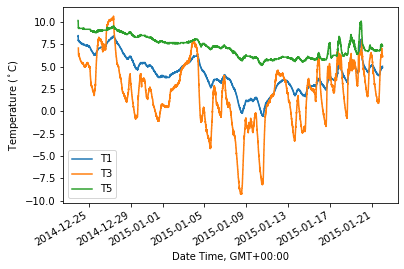

In [21]:
#Here we use an example of reading data from an Onset HOBO data logger
from olm.loggers.HoboToolkit import read_hobo_csv

#Here we import temperature data from three HOBO loggers
T1_jan = read_hobo_csv(base_path + 'data/2015-01-21/BS-T1.csv')
T3_jan = read_hobo_csv(base_path + 'data/2015-01-21/BS-T3.csv')
T5_jan = read_hobo_csv(base_path + 'data/2015-01-21/BS-T5.csv')

#Plot the data as an example to compare the three timeseries
T1_jan.Temp.plot()
T3_jan.Temp.plot()
T5_jan.Temp.plot()
legend(['T1','T3','T5'])
ylabel('Temperature ($^\circ$C)')

In [22]:
#Now we read in a couple more months (if we were clever, we'd use a for loop instead)
T1_feb = read_hobo_csv(base_path + 'data/2015-02-19/BS-T1.csv')
T3_feb = read_hobo_csv(base_path + 'data/2015-02-19/BS-T3.csv')
T5_feb = read_hobo_csv(base_path + 'data/2015-02-19/BS-T5.csv')

T1_mar = read_hobo_csv(base_path + 'data/2015-03-16/BS-T1.csv')
T3_mar = read_hobo_csv(base_path + 'data/2015-03-16/BS-T3.csv')
T5_mar = read_hobo_csv(base_path + 'data/2015-03-16/BS-T5.csv')



### The `olm.loggers.loggerScripts` module

#### Concatenating logger data

Currently, we have separate *Pandas* DataFrames for each CSV file. We can use [`pandas.concat()`](https://pandas.pydata.org/docs/reference/api/pandas.concat.html) to put together the total record for each logger.

In [ ]:
from pandas import concat

#To concatenate the DataFrames for each logger, we just provide a list of the individual DataFrames
#There are also many options described in the Pandas docs.
T1 = concat([T1_jan, T1_feb, T1_mar])
T3 = concat([T3_jan, T3_feb, T3_mar])
T5 = concat([T5_jan, T5_feb, T5_mar])

T1.Temp.plot()
T3.Temp.plot()
T5.Temp.plot()
legend(['T1','T3','T5'])
ylabel('Temperature ($^\circ$C)')

#### Joining loggers into a single `DataFrame`

Depending on how you have set them up, loggers will not always have the same timestamps. See the example below for T1 and T3, whose timestamps do not align. This causes problems when merging into a single `DataFrame`.

In [ ]:
print('Data from T1')
print(T1_jan.head())
print('Data from T3')
print(T3_jan.head())

#### Join and resample loggers

olm.loggers.loggerScripts contains a [`joinAndResampleLoggers()`](https://olm.readthedocs.io/en/master/olm.loggers.html#olm.loggers.loggerScripts.joinAndResampleLoggers) function that enables simulataneous joining of loggers and resampling onto a common timestamp index. 

In [ ]:
from olm.loggers.loggerScripts import joinAndResampleLoggers

#Provide a list of the loggers to be joined as well as the interval
# See list of frequency strings (e.g. min) that can be used in intervals here:
# https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects
# Since the three loggers contain a duplicate column name (Temp), we have to provide suffixes
# for each one to differentiate the column names.
df = joinAndResampleLoggers([T1,T3,T5], '5min', suffixes=['T1', 'T3', 'T5'])
df

In [ ]:
df.plot()
ylabel('Temperature ($^\circ$C)')

#### Applying linear corrections

Sometimes data logger values drift due to bio-fouling or other factors (particularly conductivity loggers). This drift is often removed using a linear correction based on spot measurements at the site. [`olm.loggers.loggerScripts.linear_correction()`](https://olm.readthedocs.io/en/master/olm.loggers.html#olm.loggers.loggerScripts.linear_correction) provides a function to make such corrections.

In [ ]:
#Read in some raw data logger data from a Campbell .dat file
from olm.loggers.CampbellToolkit import read_dat
Langle = read_dat(base_path + 'data/CR800_Langle_Water.dat')
Langle_cond_datalogger = 1000*Langle.Cond_Avg #Convert to muS/cm from mS/cm


In [ ]:
#Read in the spot measurements from a csv file
from pandas import read_csv
spot_meas = read_csv(base_path + 'data/Langle_data_fixed.csv', parse_dates=[[0,1]], index_col=0, na_values='NaN')
cond_spot = spot_meas['cond']


In [ ]:
from olm.loggers.loggerScripts import linear_correction
#To correct, simply provide the timeseries DataFrame and spot measurement DataFrame
#Both must have datetime indicies.
cond_corr = linear_correction(Langle_cond_datalogger, cond_spot)

In [ ]:
title('Comparing the raw and corrected series')
Langle_cond_datalogger.plot()
cond_corr.plot()
cond_spot.plot(style='ko')
legend(['Raw SpC', 'Corrected SpC', 'Spot measurements'], loc='lower right')
ylabel('SpC ($\mu S/cm$)');


#### Shifting a logger's timestamp

Sometimes the datalogger clock gets reset to the wrong value (wrong timezone, or some bizarre time in the distant future or past). As long as the offsets are correct between timestamps, it is easy to correct this shift. While this can be corrected easily with a few lines of code using Pandas functions, this happens frequently enough that I didn't want to have to reinvent the code each time. [`olm.loggers.loggerScripts.shiftLogger()` ](https://olm.readthedocs.io/en/master/olm.loggers.html#olm.loggers.loggerScripts.shiftLogger) will do this shift for us.

In [ ]:
BS4_cond = read_hobo_csv(base_path + 'data/2016-10-20/BS4-Cond.csv')
BS4_cond

This timestamps are in the distant future and can't be right. Actually the RTC chip in the HOBO Shuttle had gotten damaged by water, causing it to reset the loggers to this strange time. No worries, I know from my field notes that I downloaded this logger and restarted it last at 23:11 on 10/5/2016 UTC.

In [ ]:
from olm.loggers.loggerScripts import shiftLogger
#Just provide the DataFrame to shift and the starting timestamp desired.
#One can also shift to end at a specific time using align_at_start=False.
BS4_cond_corrected = shiftLogger(BS4_cond, '10/05/2016 23:11',align_at_start=True)

BS4_cond_corrected